# Electrical characterization of a CuPc OFET as an exercise for data analysis

## Introduction
The characterization of a transistor is an important step in the transistor fabrication cycle. These analysis can get repetitive as there are many devices being fabricated at once following different parameters, and while repetitive, the data analysis can be extensive.
This notebook illustrates an example step-by-step I followed on my MSc. research on organic field-effect transistors, but now applying my accumulated knowledge on Jupyter notebooks and machine learning in Python (data transformation and fitting with regressor objects).
***

## The data

The data were obtained through a custom software operating the measuring device. The data generated are written in .txt2 files to be further studied.

In [1]:
import pandas as pd
import numpy as np

In [7]:
import matplotlib.pyplot as plt

### Find and import the dataset

In [2]:
import os
filenames = []
data_dir = './data'
for root, folders, files in os.walk(data_dir):
    for file in files:
         if '.txt2' in file: filenames.append(file)

Using just the first .txt2 file it finds, let's check the first few lines of the datafile to know how we'll import it.

In [3]:
datafile = data_dir+'/'+filenames[0]
with open(datafile) as myfile:
    head = [next(myfile) for x in range(5)]
print('\n'.join(head))

Cycle #	V	IDS_Oupt01__-rolled--1.0000	IGS_Oupt02__-rolled--1.0000	time_Oupt03__-rolled--1.0000	

0.000000E+0	5.000000E-1	-3.413970E-11	4.112560E-11

0.000000E+0	3.750000E-1	-3.040360E-11	3.707287E-11

0.000000E+0	2.500000E-1	-3.421663E-11	3.280340E-11

0.000000E+0	1.250000E-1	-5.119703E-11	2.682847E-11



It's a .csv file with '\t' as separators. The important data are located in the columns 1 through 3.

In [4]:
dataset = pd.read_csv(datafile, delimiter='\t')
dataset = dataset.iloc[:, 1:4]

In [5]:
dataset.columns = ('V' ,'IDS', 'IGS')

In [6]:
dataset.head(3)

,V,IDS,IGS
0,0.500,-3.413970e-11,4.112560e-11
1,0.375,-3.040360e-11,3.707287e-11
2,0.250,-3.421663e-11,3.280340e-11


### Checking the data visually

Usually, transistor transconductance curves are shown in log-scale, since the main object of study is the behavior of the device during it's switching phase.

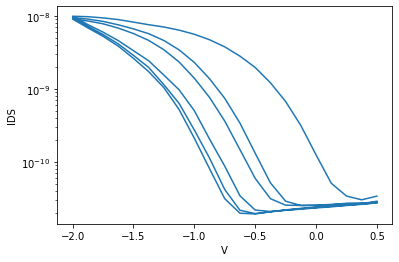

In [8]:
X = dataset['V']
y = dataset['IDS']
ax1 = plt.subplot(111)
ax1.plot(X,np.abs(y))
ax1.set_yscale('log')
ax1.set_xlabel('V')
ax1.set_ylabel('IDS')
ax1.relim()
ax1.autoscale_view()
plt.show()

At first glance, we notice that the measured transistor produced a p-type transistor curve, as it *switches on* at negative applied-voltage and *switches off* close to no-voltage applied.

There are 3 cycles of measurements. The last cycle is the most important, so let's use only that. Also, the forward sweep is our object of study, since we are analyzing the charge carriers behavior during the switching phase.

In [9]:
dataset.shape[0]/3

41.0

There are 41 data points per cycle. Let's take the last cycle only and then we take the forward sweep, assuming a cycle has only one measurement at the peak-voltage.

In [10]:
dataset = dataset.iloc[-41:-20, :]
dataset.shape

(21, 3)

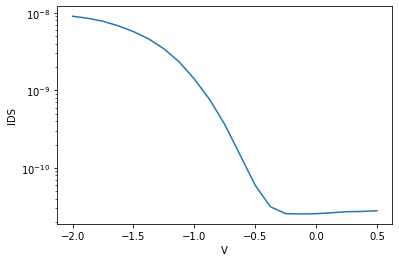

In [11]:
X = dataset['V']
y = dataset['IDS']
ax2 = plt.subplot(111)
ax2.plot(X,np.abs(y))
ax2.set_yscale('log')
ax2.set_xlabel('V')
ax2.set_ylabel('IDS')
ax2.relim()
ax2.autoscale_view()
plt.show()

That's a transfer curve of a transistor (or transconductance curve).
<div>
<img src="img/curves.png" width="400"/>
</div>

We see that our device's performance is significantly poorer than the example image, as our on-off ratio is around 3 orders of magnitude, and the example is 6.

To further analyze the charge carrier mobility of the semiconductor, we'll have to analyze the sqrt plot of IDS.

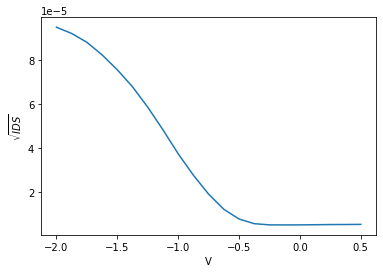

In [12]:
X = dataset['V']
y = np.sqrt(np.abs(dataset['IDS']))
ax3 = plt.subplot(111)
ax3.plot(X,y)
ax3.set_xlabel('V')
ax3.set_ylabel(r'$\sqrt{IDS}$')
ax3.relim()
ax3.autoscale_view()
ax3.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.show()

What we know:
- The square root of IDS should be a linear function of V from a certain threshold;
- The slope is important for the characterization of the transistor;
- The obtained plot curves slightly at the end.

We'll assume the data is linear in the interval V = (-1.5, -1.0) and apply a **linear regression method**.

In [13]:
lin_lims = [-1.5, -1.0]

We'll start by filtering the dataset for rows where the V is in the interval.

In [14]:
dataset = dataset.loc[(dataset['V'] >= lin_lims[0]) & (dataset['V'] <= lin_lims[1])]

In [15]:
X, y = dataset['V'], np.sqrt(np.abs(dataset['IDS']))

Since the regression algorithms take `column vectors` as input, we have to `reshape` the data.

In [16]:
X = X.values.reshape(-1,1)

In [17]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

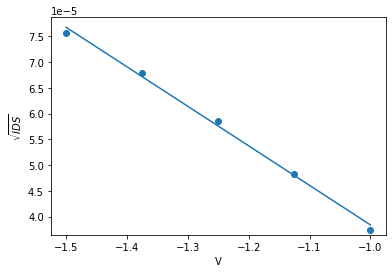

In [18]:
ax4 = plt.subplot(111)
ax4.scatter(X,y)
ax4.plot(X, np.abs(regressor.predict(X)))
ax4.set_xlabel('V')
ax4.set_ylabel(r'$\sqrt{IDS}$')
ax4.relim()
ax4.autoscale_view()
ax4.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.show()

Then, the slope to be used to determine the transistor's charge carrier mobility is

In [19]:
a = abs(regressor.coef_[0])
a

7.678322152706743e-05

Further information not available through electrical measurements are required to [calculate the charge carrier mobility](https://en.wikipedia.org/wiki/Electron_mobility#Using_saturation_mode).